In [1]:
import numpy as np
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import accuracy_score, confusion_matrix, f1_score
from sklearn.model_selection import train_test_split, cross_val_score

np.random.seed(7)

## Load data

In [2]:
data = pd.read_csv('table.csv')

o = data.Score[data.Action == "operator"]
r = data.Score[data.Action == "reask"]
c = data.Score[data.Action == "correct"]

## Some statistics

In [3]:
print("Operator count:", o.count())
print("Reask count:", r.count())
print("Correct count:", c.count())
print("\nOperator mean:", o.mean(), "min:", o.min(), "max:", o.max())
print("Reask mean:", r.mean(), "min:", r.min(), "max:", r.max())
print("Correct mean:", c.mean(), "min:", c.min(), "max:", c.max())

Operator count: 187
Reask count: 145
Correct count: 35

Operator mean: 29.38909090909091 min: 0.0 max: 100.0
Reask mean: 37.59248275862069 min: 0.0 max: 100.0
Correct mean: 86.5797142857143 min: 23.9 max: 100.0


## Data preprocessing

In [4]:
mapping = {"operator": 0, "reask": 1, "correct": 2}
data['y'] = data['Action'].map(mapping)

X = data.iloc[:, 1].astype('float64').values / 100
y = data.iloc[:, -1].values

## Visualization

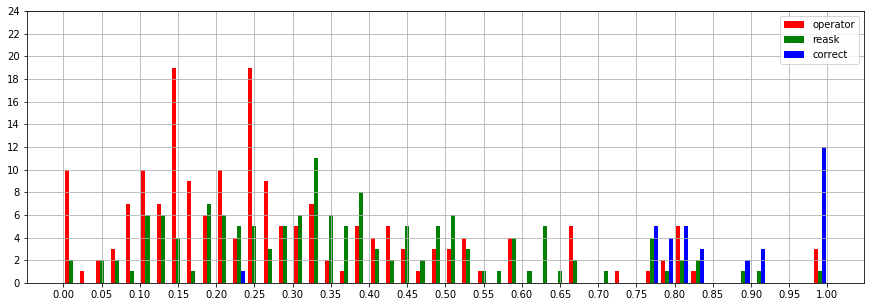

In [5]:
plt.rcParams['figure.figsize'] = (15, 5)

def plot(X, y):
    X = np.reshape(X, (-1))

    o_indices = [i for i in range(len(X)) if y[i] == 0]
    r_indices = [i for i in range(len(X)) if y[i] == 1]
    c_indices = [i for i in range(len(X)) if y[i] == 2]

    bars = [X[o_indices], X[r_indices], X[c_indices]]

    plt.hist(bars, bins=50, color=['r', 'g', 'b'])
    plt.grid()
    plt.xticks([x / 20 for x in range(21)])
    plt.yticks([y for y in range(0, 26, 2)])
    plt.legend(["operator", "reask", "correct"])
    plt.show()


plot(X, y)

## Outlier elimination

The only obvious oulier is a blue point (correct) in the confidence range [0.2; 025]

In [6]:
o_indices = [i for i in range(len(X)) if y[i] == 0]
r_indices = [i for i in range(len(X)) if y[i] == 1]
c_indices = [i for i in range(len(X)) if y[i] == 2 and X[i] > 0.5]

X = np.concatenate((X[o_indices], X[r_indices], X[c_indices])).reshape((-1, 1))
y = np.concatenate((y[o_indices], y[r_indices], y[c_indices]))

## Class size balancing

Repeating elements of minor classes till they are equal in size, then adding a little noise

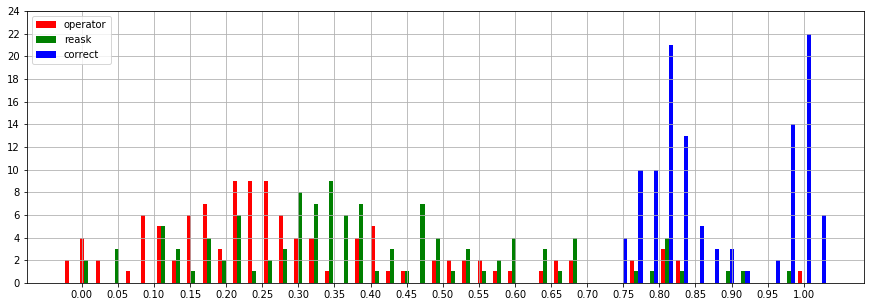

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=7)

def lenghten(A, length):
    n = length // len(A)
    return np.concatenate((n*A, A[:length - n * len(A)])).astype(int)

def balance(X, y):    
    o_indices = [i for i in range(len(X)) if y[i] == 0]
    r_indices = [i for i in range(len(X)) if y[i] == 1]
    c_indices = [i for i in range(len(X)) if y[i] == 2]

    length = max([len(o_indices), len(r_indices), len(c_indices)])

    o_indices = lenghten(o_indices, length)
    r_indices = lenghten(r_indices, length)
    c_indices = lenghten(c_indices, length)

    np.random.shuffle(o_indices)
    np.random.shuffle(r_indices)
    np.random.shuffle(c_indices)

    X_norm = np.concatenate((X[o_indices], X[r_indices], X[c_indices])).reshape((-1, 1))
    noise = np.random.normal(0, 0.015, len(X_norm)).reshape((-1, 1))
    X_norm += noise
    y_norm = np.concatenate((y[o_indices], y[r_indices], y[c_indices]))
    return X_norm, y_norm

X_train_norm, y_train_norm = balance(X_train, y_train)

plot(X_train_norm, y_train_norm)

## Models training

In [8]:
def get_accuracy(model):
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average="weighted")
    
    # draw confusion matrix:
    cm = confusion_matrix(y_test, y_pred)
    fig, ax = plt.subplots(figsize=(2, 2))
    im = ax.imshow(cm)
    labels = ["operator", "reask", "correct"]
    ax.set_title("Confusion matrix")
    ax.set_xticklabels([0] + labels)
    ax.set_yticklabels([''] + labels)

    for i, v in enumerate(cm):
        for j, x in enumerate(v):
            text = ax.text(j, i, x, ha="center", va="center", color="w")
    plt.show()
    return np.round(100 * accuracy, 2), np.round(100 * f1, 2)

def get_threshs(model, k=1000):
    X_gen = np.array([[x / k] for x in range(k + 1)])
    y_gen = model.predict(X_gen)
    result = []
    for i in range(1000):
        assert y_gen[i] <= y_gen[i + 1]
        if y_gen[i] < y_gen[i + 1]:
            result.append((i + 0.5) / 1000)
    assert len(result) == 2
    return result[0], result[1]

def print_accuracy(model, name):
    model.fit(X_train_norm, y_train_norm)
    acc, f1 = get_accuracy(model)
    print(f"{name} accuracy: {acc}%")
    print(f"{name} f1-score: {f1}%")
    print(f"Thresholds: {get_threshs(model)}")

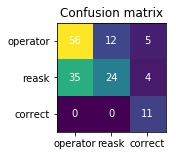

LogisticRegression accuracy: 61.9%
LogisticRegression f1-score: 60.0%
Thresholds: (0.3515, 0.7175)


In [9]:
lr = LogisticRegression(C=1e2, penalty='l2', solver='lbfgs', max_iter=200,
                        multi_class='multinomial', random_state=7)
print_accuracy(lr, "LogisticRegression")

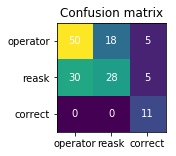

SVC poly accuracy: 60.54%
SVC poly f1-score: 59.62%
Thresholds: (0.3045, 0.7005)


In [10]:
svc_poly = SVC(C=1e2, kernel='poly', gamma=1, degree=3, coef0=1, random_state=7)
print_accuracy(svc_poly, "SVC poly")

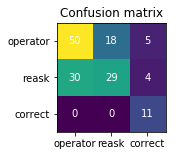

SVC rbf accuracy: 61.22%
SVC rbf f1-score: 60.37%
Thresholds: (0.2945, 0.7105)


In [11]:
svc_rbf = SVC(C=1e4, kernel='rbf', gamma=1, random_state=7)
print_accuracy(svc_rbf, "SVC rbf")

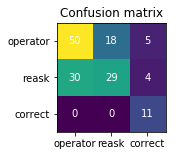

DecisionTree accuracy: 61.22%
DecisionTree f1-score: 60.37%
Thresholds: (0.2895, 0.7155)


In [12]:
tree = DecisionTreeClassifier(max_depth=2, random_state=7)
print_accuracy(tree, "DecisionTree")

## Result by hands

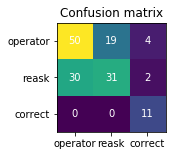

By hands accuracy: 62.59%
By hands f1-score: 61.85%
Thresholds: (0.2905, 0.7705)


In [13]:
class ByHands(object):
    def __init__(self, a, b):
        self.a, self.b = a, b
        
    def fit(self, X, y):
        pass
    
    def predict(self, X):
        y_pred = []
        for x in X.reshape((-1)):
            if x <= self.a:
                y_pred.append(0)
            elif x <= self.b:
                y_pred.append(1)
            else:
                y_pred.append(2)
        return np.array(y_pred)

by_hands = ByHands(0.29, 0.77)
print_accuracy(by_hands, "By hands")

## Hierarchical model

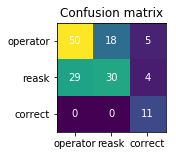

HierarchicalModel accuracy: 61.9%
HierarchicalModel f1-score: 61.15%
Thresholds: (0.2865, 0.7155)


In [14]:
class HierarchicalModel(object):
    def __init__(self):
        self.first = DecisionTreeClassifier(max_depth=1, random_state=7)
        self.second = SVC(C=1e5, kernel='rbf', gamma=1, random_state=7)
        
    def fit(self, X, y):
        y1 = [0 if i < 2 else 2 for i in y]
        self.first.fit(X, y1)
        
        X2, y2 = [], []
        for i in range(len(X)):
            if y[i] < 2:
                X2.append(X[i])
                y2.append(y[i])
        self.second.fit(X2, y2)
    
    def predict(self, X):
        y1 = self.first.predict(X)
        y2 = self.second.predict(X)
        y_pred = [y1[i] if y1[i] == 2 else y2[i] for i in range(len(X))]
        return np.array(y_pred)

hmodel = HierarchicalModel()
print_accuracy(hmodel, "HierarchicalModel")

## Metrics
As required in the task, I propose F1_score(weighted) metric and compute it on the whole data, while the models are only trained on the train set. These results differ from the results above, because they were computed on the test set.

In [15]:
def print_f1(model, name):
    f1 = f1_score(y, model.predict(X), average="weighted")
    print(f"{name}: {np.round(100 * f1, 2)}%")
          
print_f1(lr, "Logistic")
print_f1(svc_poly, "SVC poly")
print_f1(svc_rbf, "SVC rbf")
print_f1(tree, "DecisionTree")
print_f1(by_hands, "By hands")
print_f1(hmodel, "HierarchicalModel")

Logistic: 60.19%
SVC poly: 63.24%
SVC rbf: 63.55%
DecisionTree: 63.57%
By hands: 64.12%
HierarchicalModel: 63.87%


## Final training

In [16]:
X_norm, y_norm = balance(X, y)

hmodel = HierarchicalModel()
hmodel.fit(X_norm, y_norm)
print(get_threshs(hmodel))

(0.2635, 0.7655)
